# Vilnius public transport passengers traffic analysis

This analysis is performed on publicly available data https://github.com/vilnius/keleiviu-srautai.git. Data consists of 2016 year passengers flow data (entering bus (IN) and leaving the bus (OUT)).

## Importing necessary libraries

First of all I am importing necessary libraries.

In [1]:
import os
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins as folium_plugins
import calendar

%matplotlib inline

# set floating point display format
pd.options.display.float_format = "{:.2f}".format

## Data preparation

Data must be cleaned and reformated before performing any analysis.

In [2]:
traffic_dfs = [pd.read_csv(os.path.join('data', f),
                           sep=';',
                           usecols=['Day',
                                    'Time',
                                    'Line',
                                    'Direction',
                                    'Stop name',
                                    'Stop number',
                                    'Passeng. in',
                                    'Passeng. out',
                                    'Tickets',
                                    'Pass. in [1]',
                                    'Pass. out [1]',
                                    'Pass. in [2]',
                                    'Pass. out [2]',
                                    'Pass. in [3]',
                                    'Pass. out [3]',
                                    'Pass. in [4]',
                                    'Pass. out [4]', ],
                           encoding='utf-8')
               for f in os.listdir('data') if f.endswith('csv') and not f.startswith('stops')]

traffic_df = pd.concat(traffic_dfs)
traffic_df['Passeng. in'] = traffic_df['Passeng. in'].fillna(0)
traffic_df['Passeng. out'] = traffic_df['Passeng. out'].fillna(0)
traffic_df['Pass. in [1]'] = traffic_df['Pass. in [1]'].fillna(0)
traffic_df['Pass. out [1]'] = traffic_df['Pass. out [1]'].fillna(0)
traffic_df['Pass. in [2]'] = traffic_df['Pass. in [2]'].fillna(0)
traffic_df['Pass. out [2]'] = traffic_df['Pass. out [2]'].fillna(0)
traffic_df['Pass. in [3]'] = traffic_df['Pass. in [3]'].fillna(0)
traffic_df['Pass. out [3]'] = traffic_df['Pass. out [3]'].fillna(0)
traffic_df['Pass. in [4]'] = traffic_df['Pass. in [4]'].fillna(0)
traffic_df['Pass. out [4]'] = traffic_df['Pass. out [4]'].fillna(0)

traffic_df['passengers_in'] = traffic_df['Passeng. in'] + \
                              traffic_df['Pass. in [1]'] + \
                              traffic_df['Pass. in [2]'] + \
                              traffic_df['Pass. in [3]'] + \
                              traffic_df['Pass. in [4]']

traffic_df['passengers_out'] = traffic_df['Passeng. out'] + \
                              traffic_df['Pass. out [1]'] + \
                              traffic_df['Pass. out [2]'] + \
                              traffic_df['Pass. out [3]'] + \
                              traffic_df['Pass. out [4]']

traffic_df['passengers_in'] = traffic_df['passengers_in'].astype('int64')
traffic_df['passengers_out'] = traffic_df['passengers_out'].astype('int64')

traffic_df['datetime'] = pd.to_datetime(traffic_df['Day'] + ' ' + traffic_df['Time'])

traffic_df = traffic_df.drop(['Passeng. in',
                              'Passeng. out',
                              'Pass. in [1]',
                              'Pass. out [1]',
                              'Pass. in [2]',
                              'Pass. out [2]',
                              'Pass. in [3]',
                              'Pass. out [3]',
                              'Pass. in [4]',
                              'Pass. out [4]',
                              'Day',
                              'Time',
                              'Tickets',
                              'Stop name'], axis=1)

traffic_df = traffic_df.rename(columns={'Direction': 'direction', 
                                        'Stop number': 'stop_number',
                                        'Line': 'line'})

display(traffic_df.describe())

,stop_number,passengers_in,passengers_out
count,5529409.00,5529409.00,5529409.00
mean,1994.36,0.15,1.52
std,1735.79,1128.17,1702.94
min,0.00,-999996.00,-999997.00
25%,913.00,0.00,0.00
50%,1918.00,0.00,0.00
75%,2630.00,2.00,2.00
max,65534.00,1231.00,1000013.00


After inspecting data statistics I can see some abnormal values: passengers_in between -999996 and 1231, passengers_out between -999997 and 1000013. All abnormal data are removed leaving passengers in/out numbers between 0 and 20. After that I remove rows that has no meaningful information (IN and OUT equal to 0).

In [3]:
traffic_df = traffic_df[(traffic_df['passengers_in'] >= 0) & (traffic_df['passengers_in'] <= 20)]
traffic_df = traffic_df[(traffic_df['passengers_out'] >= 0) & (traffic_df['passengers_out'] <= 20)]

traffic_df = traffic_df[~((traffic_df['passengers_in'] == 0) & (traffic_df['passengers_out'] == 0))]

display(traffic_df.describe())

,stop_number,passengers_in,passengers_out
count,3352186.00,3352186.00,3352186.00
mean,1935.27,2.55,2.63
std,1539.36,3.22,3.35
min,0.00,0.00,0.00
25%,803.00,0.00,0.00
50%,1902.00,1.00,1.00
75%,2415.00,3.00,4.00
max,65534.00,20.00,20.00


Now passengers traffic data looks OK. Time to prepare stops data.

In [4]:
def str_2_int(string, default=None):
    try:
        return int(string)
    except ValueError:
        return default


stop_df = pd.read_csv(os.path.join('data', 'stops_coordinates.csv'),
                      sep=',',
                      quotechar='"')

stop_df = stop_df.rename(columns={'Stop number': 'stop_number',
                                  'Stop name': 'stop_name',
                                  'Lng': 'lng',
                                  'Lat': 'lat'})

display(stop_df.dtypes)
display(stop_df.describe())

stop_number     object
stop_name       object
lng            float64
lat            float64
dtype: object

,lng,lat
count,1479.00,1479.00
mean,25.27,54.69
std,0.08,0.05
min,25.03,54.56
25%,25.22,54.67
50%,25.27,54.69
75%,25.32,54.72
max,25.52,54.83


Stop number field in stop data is of type string (contains strings "1002a", "101b") and in passengers traffic data field type is integer. Cause I am planning to join those two data frames, using stop number field I have to make those fields the same type (integer). Stop number of string type never appiered in passengers traffic data so stops with stop number field of type string where removed from stops dataframe.

In [5]:
stop_df['stop_number'] = stop_df['stop_number'].apply(str_2_int)
stop_df = stop_df[stop_df['stop_number'].notnull()]

stop_df['stop_number'] = stop_df['stop_number'].astype('int64')

display(stop_df.dtypes)
display(stop_df.describe())

stop_number      int64
stop_name       object
lng            float64
lat            float64
dtype: object

,stop_number,lng,lat
count,1408.00,1408.00,1408.00
mean,2432.26,25.27,54.69
std,1409.81,0.08,0.05
min,101.00,25.03,54.56
25%,1317.75,25.22,54.67
50%,2317.50,25.27,54.69
75%,3517.25,25.32,54.73
max,5300.00,25.46,54.83


I have two separate dataframes, need to join them to have on dataframe that I am going to analyze.

In [6]:
df = pd.merge(traffic_df, stop_df, on='stop_number')

display(df.dtypes)
display(df.describe())

line                      object
direction                 object
stop_number                int64
passengers_in              int64
passengers_out             int64
datetime          datetime64[ns]
stop_name                 object
lng                      float64
lat                      float64
dtype: object

,stop_number,passengers_in,passengers_out,lng,lat
count,3191772.00,3191772.00,3191772.00,3191772.00,3191772.00
mean,2008.38,2.56,2.64,25.27,54.70
std,1309.04,3.21,3.33,0.06,0.04
min,101.00,0.00,0.00,25.09,54.58
25%,916.00,0.00,0.00,25.23,54.68
50%,1912.00,1.00,1.00,25.27,54.70
75%,2624.00,4.00,4.00,25.29,54.73
max,5206.00,20.00,20.00,25.44,54.82


Something weird before join I had 5484429 records, after joi 5197911.

In [7]:
tmp_df = traffic_df[~traffic_df['stop_number'].isin(stop_df['stop_number'])]
display(tmp_df.head())

,line,direction,stop_number,passengers_in,passengers_out,datetime
782,103,GER.VILTIES-SANTARIS,589,5,4,2016-08-28 00:11:25
789,74,STOTIS-SUBACIAUS-AP,587,1,0,2016-08-31 00:11:47
896,101,AP-SAULETEKIS,824,1,0,2016-08-21 00:14:46
903,23,STOTIS-OLANDU G.-AP,584,2,0,2016-08-18 00:14:58
918,103,GER.VILTIES-SANTARIS,589,1,0,2016-08-13 00:15:29


It seems that some passengers trafic data are still incorrect (stop number not exists in stops dataframe), so after join those incorrect values are removed.

In [8]:
df = df[['direction', 
         'line', 
         'stop_number', 
         'stop_name', 
         'passengers_in', 
         'passengers_out', 
         'lat', 
         'lng', 
         'datetime']]

display(df.head())

,direction,line,stop_number,stop_name,passengers_in,passengers_out,lat,lng,datetime
0,MARKUCIAI-FABIJONISK,10,3819,Liudo Giros st.,0,3,54.73,25.25,2016-08-19 00:00:03
1,MARKUCIAI-FABIJONISK,10,3819,Liudo Giros st.,0,1,54.73,25.25,2016-08-21 00:09:49
2,AP-ZVALGU G.-TARANDE,52,3819,Liudo Giros st.,1,0,54.73,25.25,2016-08-01 05:11:19
3,VAIKU LIGON-STOTIS,2G,3819,Liudo Giros st.,1,0,54.73,25.25,2016-08-20 05:31:24
4,AP-ZVALGU-FABIJONISK,10,3819,Liudo Giros st.,0,1,54.73,25.25,2016-08-25 05:38:34


## Passengers flow per month

First of all lets view passengers in/out count by month. To do that I need to group data by month and sum in/out numbers.

In [9]:
traffic_by_month_df = df[['datetime', 
                          'passengers_in', 
                          'passengers_out']].resample('M', on='datetime').sum()
traffic_by_month_df.index = traffic_by_month_df.index.strftime('%Y-%m')
traffic_by_month_df.index.name = 'datetime'
display(traffic_by_month_df.head())

,passengers_in,passengers_out
datetime,,
2016-01,660906,689935
2016-02,684491,713276
2016-03,690116,717042
2016-04,695794,718885
2016-05,755274,775656


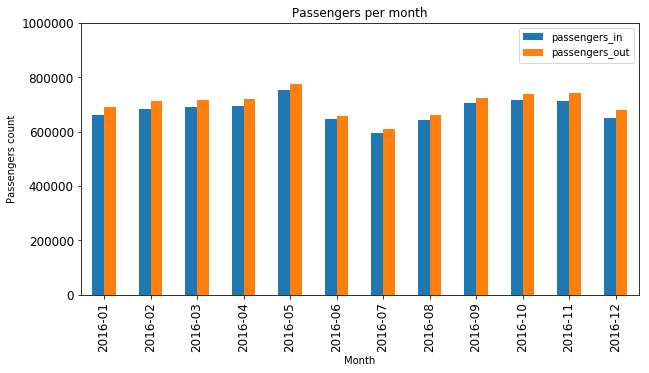

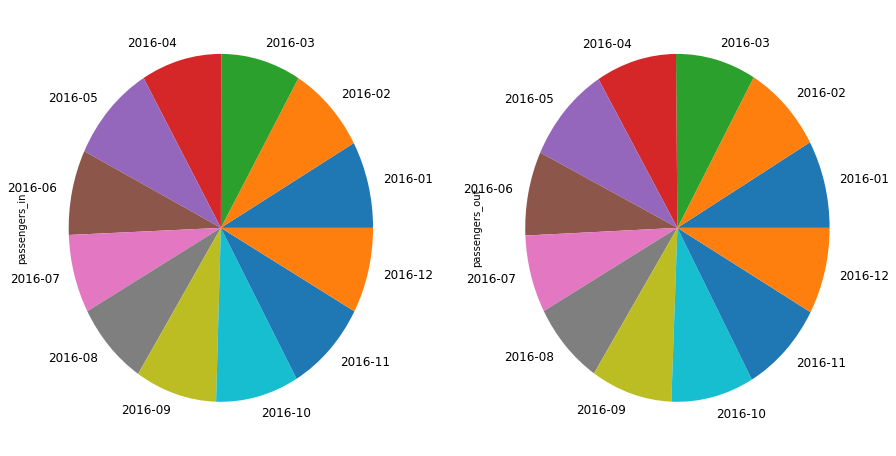

In [10]:
ax = traffic_by_month_df.plot(kind='bar',
                              figsize=(10, 5), 
                              fontsize=12)
ax.set_xlabel('Month')
ax.set_ylabel('Passengers count')
ax.set_title('Passengers per month')
ax.set_ylim(0, 1000000)

traffic_by_month_df.plot(kind='pie', 
                         subplots=True, 
                         figsize=(15, 8), 
                         fontsize=12,
                         legend=False)

plt.show()

Usage of Vilnius public transport rises till May, then it starts to decrease and after the summer, from August it starts to increase again. Number of passengers in and out are different, it may be because automatic passengers counters that are using in buses are not accurate.

## Passengers IN/OUT heatmap

Lets plot passengers flow heatmaps. To do that i need group data by month and stop.

In [11]:
traffic_by_stop_df = df.groupby([df['datetime'].dt.month, df['lat'], df['lng']])['passengers_in', 
                                                                                 'passengers_out'].sum().reset_index()
traffic_by_stop_df = traffic_by_stop_df.rename(columns={'datetime': 'month'})
display(traffic_by_stop_df.head())

,month,lat,lng,passengers_in,passengers_out
0,1,54.58,25.20,477,470
1,1,54.58,25.20,18,217
2,1,54.58,25.21,50,4
3,1,54.59,25.21,12,24
4,1,54.59,25.21,26,1


Now lets check where passengers are traveling from every month.

In [12]:
map_vilnius = folium.Map(location=[54.685010, 25.274211], zoom_start = 11)
heat_data = [[[row['lat'], row['lng'], row['passengers_in']] for index, row in traffic_by_stop_df[traffic_by_stop_df['month'] == i].iterrows()] for i in range(1, 13)]

heatmap = folium_plugins.HeatMapWithTime(heat_data,
                                         index=['%s month' % i for i in range(1, 13)],
                                         min_opacity=0.15,
                                         max_opacity=0.7,
                                         scale_radius=False,
                                         use_local_extrema=True,
                                         radius=20)

map_vilnius.add_child(heatmap)
# map_vilnius.save('docs/in_heatmap.html')
map_vilnius

Main courses: Žirmūnai, Ladynai, Baltupiai, Santariškės, Šnipiškės and Savanorių pr. What is more we can see ow different seasons and trips changes influences passengers traffic course.


Now lets see where passengers are traveling to the most.

In [13]:
map_vilnius = folium.Map(location=[54.685010, 25.274211], zoom_start = 11)
heat_data = [[[row['lat'], row['lng'], row['passengers_out']] for index, row in traffic_by_stop_df[traffic_by_stop_df['month'] == i].iterrows()] for i in range(1, 13)]

heatmap = folium_plugins.HeatMapWithTime(heat_data,
                                         index=['%s month' % i for i in range(1, 13)],
                                         min_opacity=0.15,
                                         max_opacity=0.7,
                                         scale_radius=False,
                                         use_local_extrema=True,
                                         radius=20)

map_vilnius.add_child(heatmap)
# map_vilnius.save('docs/out_heatmap.html')
map_vilnius

Courses are the same as with TO data.

## Routes analysis


Now lets look at most popular routes that passengers are traveling (by passengers IN count).

In [14]:
popular_in_routes_df = df.groupby([df['datetime'].dt.month, df['direction']])['passengers_in'].sum().reset_index()
popular_in_routes_df = popular_in_routes_df.rename(columns={'datetime': 'month'})
popular_in_routes_df = popular_in_routes_df.sort_values(['month', 'passengers_in'], ascending=[True, False])
popular_in_routes_df = popular_in_routes_df.groupby(popular_in_routes_df['month']).head(5)
popular_in_routes_df = popular_in_routes_df.pivot(index='direction', columns='month', values='passengers_in')
display(popular_in_routes_df)

month,1,2,3,4,5,6,7,8,9,10,11,12
direction,,,,,,,,,,,,
ATEITIES G.-BUKCIAI,22877.00,28539.00,26773.00,32533.00,24279.00,24060.00,21323.00,22403.00,nan,27341.00,31723.00,22878.00
ATEITIES-SILTNAMIU G,nan,18661.00,nan,nan,nan,nan,nan,nan,17258.00,nan,nan,nan
BUKCIAI-ATEITIES G.,23850.00,31564.00,29210.00,34108.00,26333.00,26846.00,23378.00,24350.00,21292.00,29793.00,35449.00,24256.00
CENTRAS-TARANDE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16864.00,17577.00
FABIJONISKES-MARKUCI,nan,21488.00,24940.00,25211.00,33278.00,21891.00,20354.00,23088.00,26094.00,25649.00,26255.00,22120.00
LAZDYNAI-CENTRAS,nan,nan,nan,nan,nan,nan,nan,15491.00,nan,nan,nan,nan
LAZDYNAI-SANTARISKES,21110.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MARKUCIAI-FABIJONISK,18565.00,21678.00,25708.00,26425.00,33624.00,21914.00,21307.00,23518.00,27879.00,27115.00,27298.00,22979.00
PASILAICIAI-SAULETEK,nan,nan,nan,nan,nan,nan,18209.00,nan,nan,nan,nan,nan


Directions ATEITIES G.-BUKCIAI, BUKCIAI-ATEITIES G, FABIJONISKES-MARKUCI, MARKUCIAI-FABIJONISK are popular all year, other directions load depends on season and other factors.


Now lets look at most popular routes that passengers are traveling (by passengers OUT count).

In [15]:
popular_out_routes_df = df.groupby([df['datetime'].dt.month, df['direction']])['passengers_out'].sum().reset_index()
popular_out_routes_df = popular_out_routes_df.rename(columns={'datetime': 'month'})
popular_out_routes_df = popular_out_routes_df.sort_values(['month', 'passengers_out'], ascending=[True, False])
popular_out_routes_df = popular_out_routes_df.groupby(popular_out_routes_df['month']).head(5)
popular_out_routes_df = popular_out_routes_df.pivot(index='direction', columns='month', values='passengers_out')
display(popular_out_routes_df)

month,1,2,3,4,5,6,7,8,9,10,11,12
direction,,,,,,,,,,,,
ANTAKALNIS-BAJORAI,nan,nan,nan,nan,nan,nan,nan,nan,nan,17767.00,nan,nan
ATEITIES G.-BUKCIAI,24064.00,30056.00,28118.00,34151.00,25232.00,24820.00,22133.00,23106.00,17922.00,28649.00,33854.00,24446.00
ATEITIES-SILTNAMIU G,nan,18498.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BUKCIAI-ATEITIES G.,23919.00,31693.00,29447.00,34176.00,26407.00,26390.00,23594.00,24625.00,20754.00,29115.00,35134.00,23949.00
CENTRAS-TARANDE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,18460.00,19251.00
FABIJONISKES-MARKUCI,nan,22430.00,25709.00,25969.00,33949.00,22317.00,20839.00,23008.00,27267.00,26789.00,27489.00,22905.00
LAZDYNAI-CENTRAS,nan,nan,nan,nan,nan,nan,nan,16485.00,nan,nan,nan,nan
LAZDYNAI-SANTARISKES,22651.00,nan,nan,nan,nan,nan,nan,nan,17535.00,nan,nan,nan
MARKUCIAI-FABIJONISK,19450.00,22791.00,27215.00,27419.00,34706.00,22582.00,21884.00,24143.00,28536.00,27898.00,27868.00,23881.00


Directions ATEITIES G.-BUKCIAI, BUKCIAI-ATEITIES G, FABIJONISKES-MARKUCI, MARKUCIAI-FABIJONISK are popular all year, other directions load depends on season and other factors.


Popular directions IN/OUT are the same.

Now lets check "unpopular" directions by passengers IN/OUT count.

In [16]:
popular_in_routes_df = df.groupby([df['datetime'].dt.month, df['direction']])['passengers_in'].sum().reset_index()
popular_in_routes_df = popular_in_routes_df.rename(columns={'datetime': 'month'})
popular_in_routes_df = popular_in_routes_df.sort_values(['month', 'passengers_in'], ascending=[True, True])
popular_in_routes_df = popular_in_routes_df.groupby(popular_in_routes_df['month']).head(5)
popular_in_routes_df = popular_in_routes_df.pivot(index='direction', columns='month', values='passengers_in')
display(popular_in_routes_df)

month,1,2,3,4,5,6,7,8,9,10,11,12
direction,,,,,,,,,,,,
2TP-NARBUTO-ZVERYNAS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
ANTAK-KAIRENAI-ANTAK,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan
AP-ANTAKALNIS-PARKO,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
AP-ATEITIES G.,nan,nan,nan,nan,nan,nan,nan,2.00,nan,nan,nan,nan
AP-ATEITIES-FABIJON,nan,nan,0.00,nan,nan,nan,1.00,nan,nan,0.00,nan,0.00
AP-ATEITIES-PASILAIC,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan
AP-KALV-ANTAKALNIS,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan
AP-KALVARIJU-ZVERYNA,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan
AP-MILASIAUS-ANTAVIL,0.00,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan


In [17]:
popular_out_routes_df = df.groupby([df['datetime'].dt.month, df['direction']])['passengers_out'].sum().reset_index()
popular_out_routes_df = popular_out_routes_df.rename(columns={'datetime': 'month'})
popular_out_routes_df = popular_out_routes_df.sort_values(['month', 'passengers_out'], ascending=[True, True])
popular_out_routes_df = popular_out_routes_df.groupby(popular_out_routes_df['month']).head(5)
popular_out_routes_df = popular_out_routes_df.pivot(index='direction', columns='month', values='passengers_out')
display(popular_out_routes_df)

month,1,2,3,4,5,6,7,8,9,10,11,12
direction,,,,,,,,,,,,
0,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2TP-NARBUTO-ZVERYNAS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00
ANTAK-KAIRENAI-ANTAK,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan
AP-ANTAKALNIS-ZOLYNO,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00,nan,nan
AP-KALVARIJU-STOTIS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00
AP-MILASIAUS-ANTAVIL,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AP-OLANDU G.-ROKANT,nan,nan,nan,nan,nan,nan,nan,2.00,1.00,nan,nan,nan
AP-OLANDU-GRIGAICIAI,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan
AP-OLANDU-N.VILNIA,nan,2.00,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan


Almost all directions to/from depot are "unpopular" with least passengers.

## Passengers flow by week day


It is interesting to inspect passengers traffic flow by week days over year and single month. At this point I am analyzing only count of passengers IN value.

In [18]:
passengers_by_weekday_year = df.groupby([
    df['datetime'].dt.weekday.rename('weekday')])['passengers_in'].sum().reset_index()
passengers_by_weekday_year['weekday'] = passengers_by_weekday_year['weekday'] + 1
display(passengers_by_weekday_year)

,weekday,passengers_in
0,1,1251088
1,2,1290476
2,3,1289947
3,4,1273950
4,5,1251562
5,6,970639
6,7,830149


Text(0.5,1,'Over year')

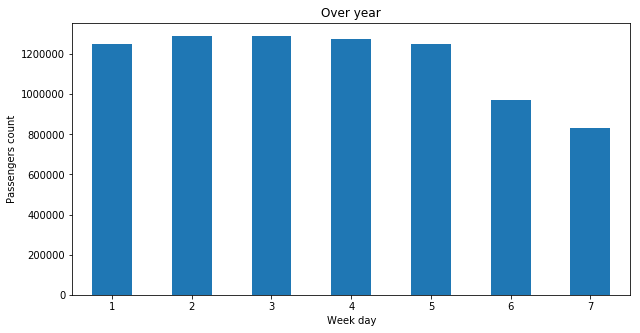

In [19]:
passengers_by_weekday_year = passengers_by_weekday_year.set_index('weekday')
ax = passengers_by_weekday_year['passengers_in'].plot(kind='bar', 
                                                      figsize=(10, 5), 
                                                      color='C0',
                                                      rot=0,
                                                      legend=False)
ax.set_xlabel('Week day')
ax.set_ylabel('Passengers count')
ax.set_title('Over year')

Passengers flow on weekends is about 35 % lower then on normal working day.

In [20]:
passengers_by_weekday = df.groupby([
    df['datetime'].dt.month.rename('month'), 
    df['datetime'].dt.weekday.rename('weekday')])['passengers_in'].sum().reset_index()
passengers_by_weekday['weekday'] = passengers_by_weekday['weekday'] + 1
display(passengers_by_weekday)

,month,weekday,passengers_in
0,1,1,102903
1,1,2,104760
2,1,3,95443
3,1,4,94316
4,1,5,105657
5,1,6,79475
6,1,7,78352
7,2,1,124438
8,2,2,96301
9,2,3,108566


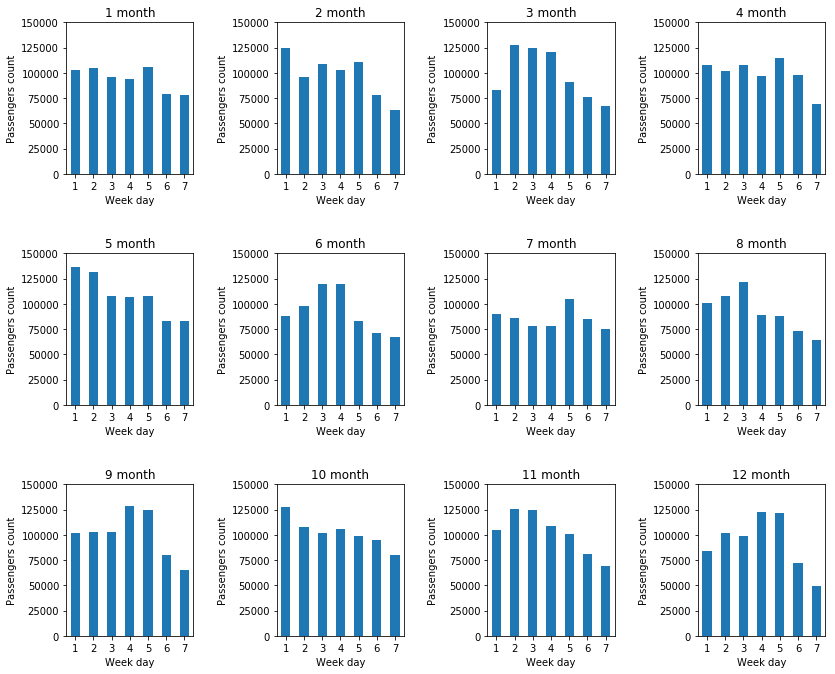

In [21]:
passengers_by_weekday = passengers_by_weekday.set_index('weekday')

fig, axes = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()

axes_list = [item for sublist in axes for item in sublist] 

for month_num in range(1, 13):
    ax = passengers_by_weekday[passengers_by_weekday['month'] == month_num][['passengers_in']].plot(kind='bar', 
                                                                                                    figsize=(12, 10), 
                                                                                                    ax=axes_list[month_num - 1], 
                                                                                                    rot=0,
                                                                                                    legend=False)
    ax.set_xlabel('Week day')
    ax.set_ylabel('Passengers count')
    ax.set_title('%s month' % str(month_num))
    ax.set_ylim(0,150000)

At summer time passengers flow decreases. On 9 month Thursday and Friday is almost 20 % passengers flow increase compared with begining of the week, I guess it is because 2016-09-01 (Thursday) is start of the session.

## Passengers flow by hours

I am interesting how passengers flow changes depending on time of the day over year and single month. At this point I am analyzing only count of passengers IN value. Hourly counts are grouped into to ranges of 4 hours.

In [22]:
passengers_by_hours_year = df.groupby([
    df['datetime'].dt.weekday.rename('weekday'),
    pd.cut(df['datetime'].dt.hour.rename('hour'), [0, 4, 8, 12, 16, 20, 24])])['passengers_in'].sum().reset_index()

passengers_by_hours_year['weekday'] = passengers_by_hours_year['weekday'] + 1
passengers_by_hours_year['weekday_name'] = passengers_by_hours_year['weekday'].apply(lambda x: calendar.day_name[x - 1])
passengers_by_hours_year = passengers_by_hours_year.set_index(['weekday_name', 'hour'])

display(passengers_by_hours_year)

weekday  passengers_in
weekday_name hour                            
Monday       (0, 4]          1           1485
             (4, 8]          1         270025
             (8, 12]         1         273788
             (12, 16]        1         390177
             (16, 20]        1         260149
             (20, 24]        1          55062
Tuesday      (0, 4]          2           1699
             (4, 8]          2         282055
             (8, 12]         2         287885
             (12, 16]        2         397125
             (16, 20]        2         264624
             (20, 24]        2          56914
Wednesday    (0, 4]          3           1558
             (4, 8]          3         286270
             (8, 12]         3         282598
             (12, 16]        3         393771
             (16, 20]        3         268543
             (20, 24]        3          57023
Thursday     (0, 4]          4           1645
             (4, 8]          4         277613
             (8, 12]         4         282990
             (12, 16]        4         390808
             (16, 20]        4         261925
             (20, 24]        4          58846
Friday       (0, 4]          5           1446
             (4, 8]          5         267843
             (8, 12]         5         283547
             (12, 16]        5         396515
             (16, 20]        5         236164
             (20, 24]        5          65645
Saturday     (0, 4]          6           9049
             (4, 8]          6         135472
             (8, 12]         6         261696
             (12, 16]        6         282481
             (16, 20]        6         205649
             (20, 24]        6          71947
Sunday       (0, 4]          7           6933
             (4, 8]          7         102520
             (8, 12]         7         231272
             (12, 16]        7         247785
             (16, 20]        7         182878
             (20, 24]        7          54108

Text(0.5,1,'Over year')

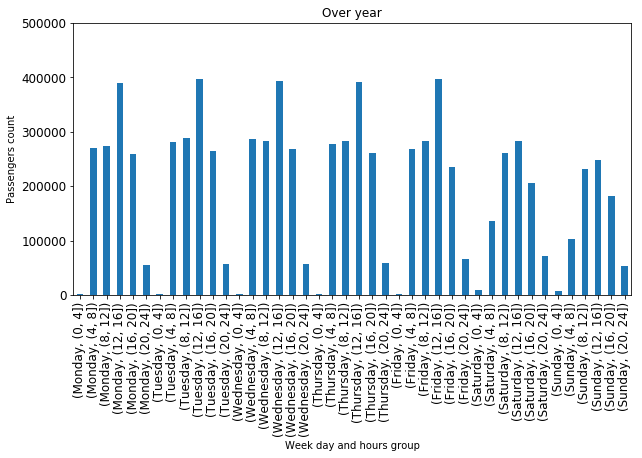

In [23]:
ax = passengers_by_hours_year['passengers_in'].plot(kind='bar', 
                                                    figsize=(10, 5), 
                                                    color='C0',
                                                    fontsize=12,
                                                    legend=False)
ax.set_ylim(0,500000)
ax.set_xlabel('Week day and hours group')
ax.set_ylabel('Passengers count')
ax.set_title('Over year')

In [24]:
passengers_by_hours = df.groupby([
    df['datetime'].dt.month.rename('month'), 
    df['datetime'].dt.weekday.rename('weekday'),
    pd.cut(df['datetime'].dt.hour.rename('hour'), [0, 4, 8, 12, 16, 20, 24])])['passengers_in'].sum().reset_index()

passengers_by_hours['weekday'] = passengers_by_hours['weekday'] + 1
passengers_by_hours['weekday_name'] = passengers_by_hours['weekday'].apply(lambda x: calendar.day_name[x - 1])

display(passengers_by_hours)

,month,weekday,hour,passengers_in,weekday_name
0,1,1,"(0, 4]",135,Monday
1,1,1,"(4, 8]",23826,Monday
2,1,1,"(8, 12]",21671,Monday
3,1,1,"(12, 16]",32833,Monday
4,1,1,"(16, 20]",20417,Monday
5,1,1,"(20, 24]",3975,Monday
6,1,2,"(0, 4]",114,Tuesday
7,1,2,"(4, 8]",24258,Tuesday
8,1,2,"(8, 12]",22698,Tuesday
9,1,2,"(12, 16]",33335,Tuesday


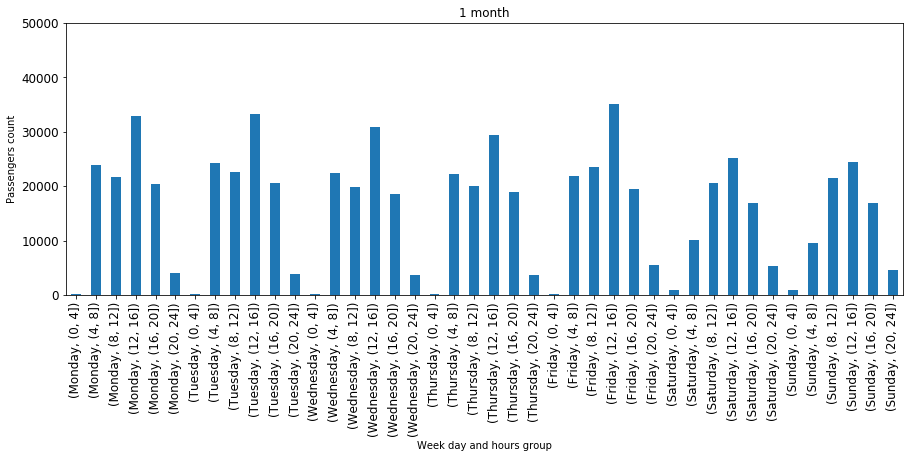

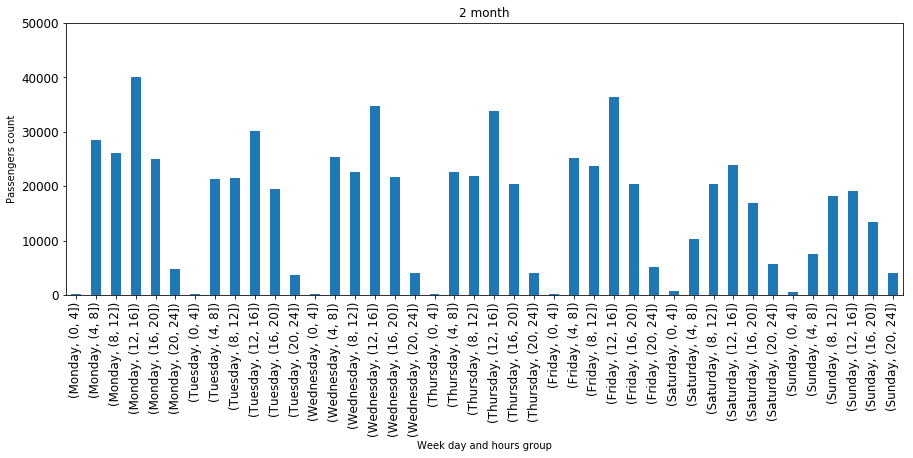

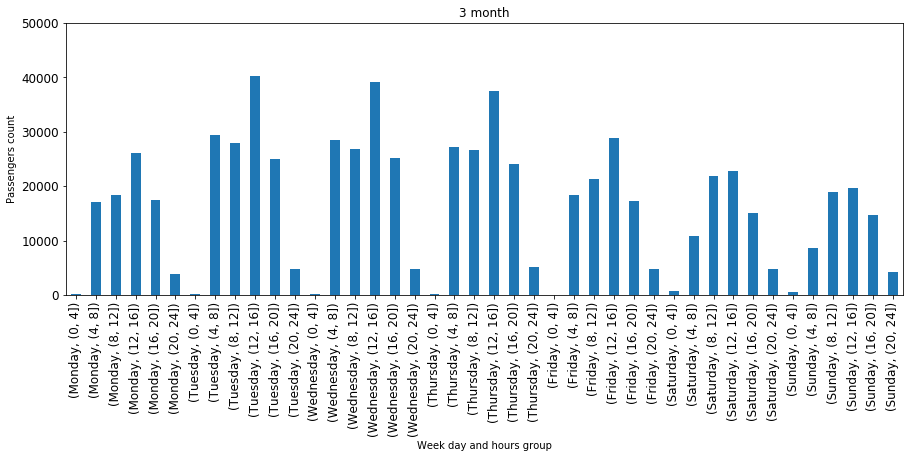

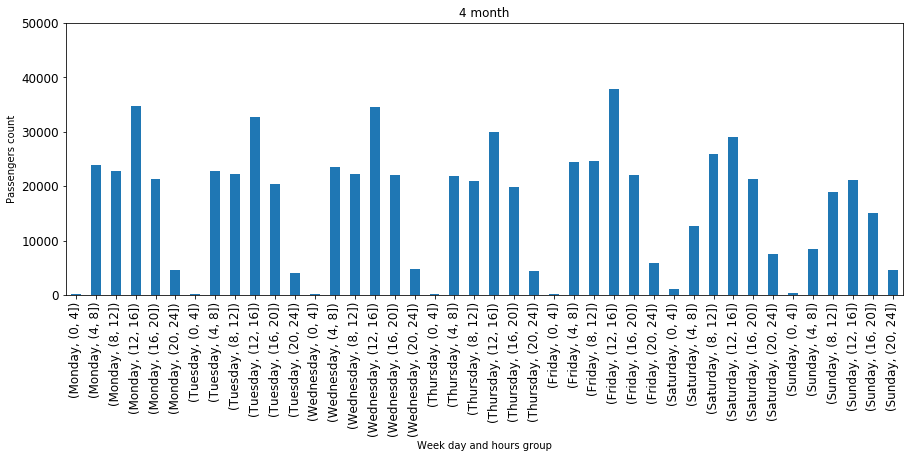

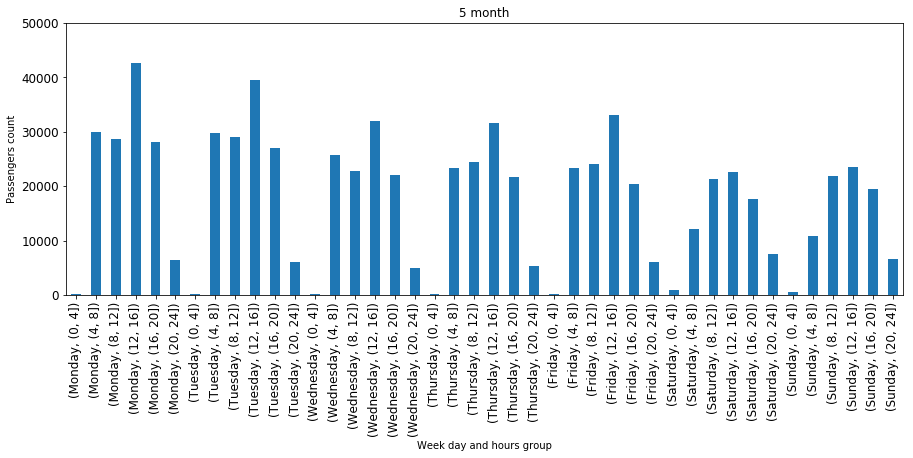

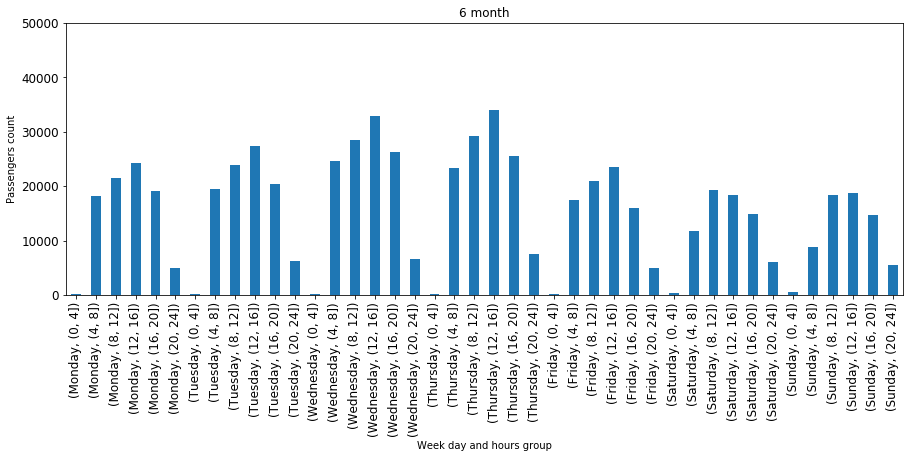

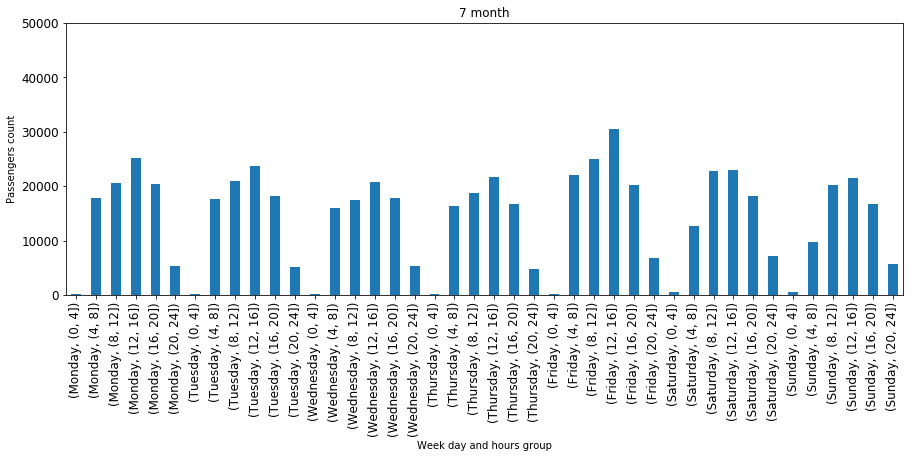

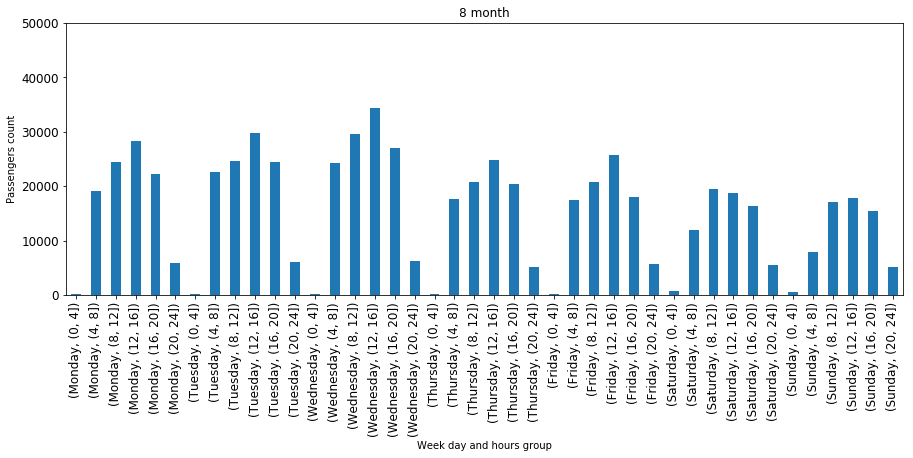

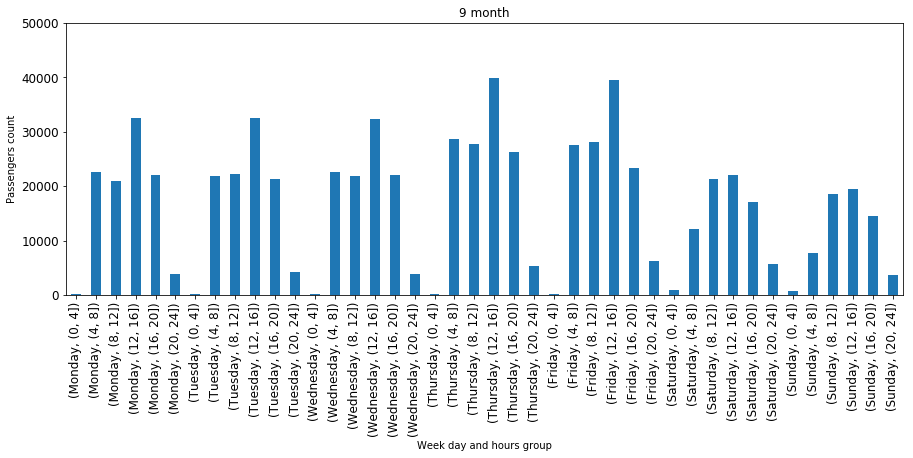

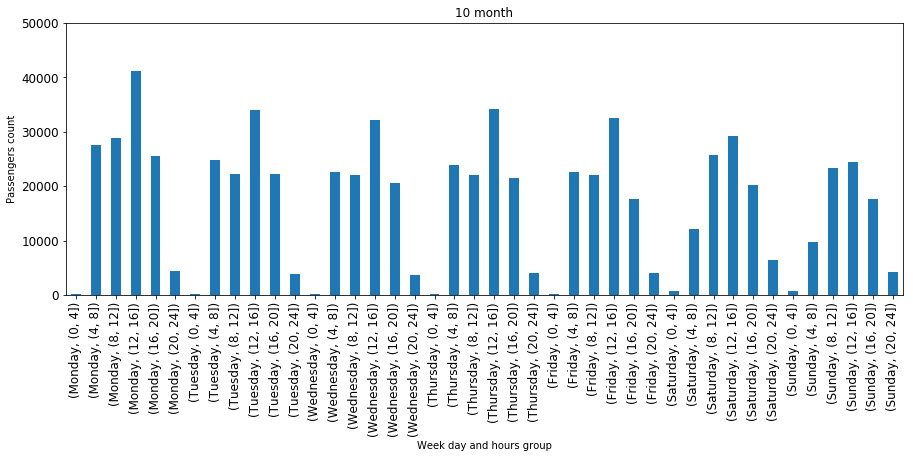

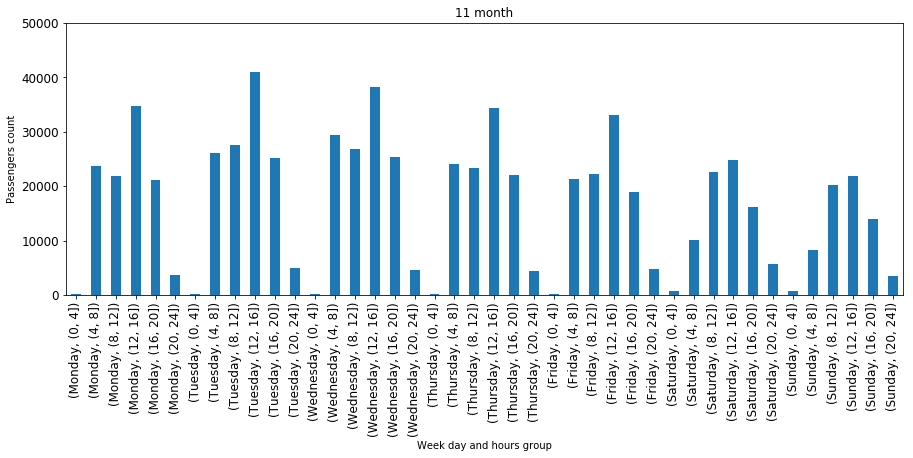

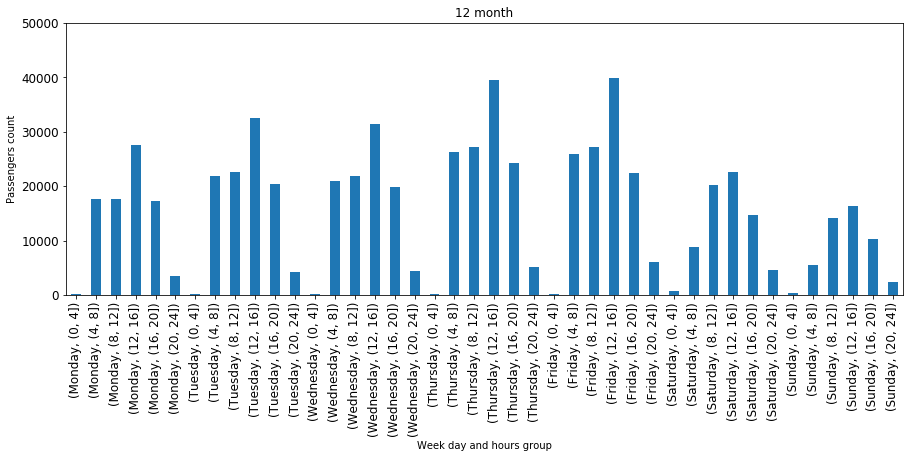

In [25]:
passengers_by_hours = passengers_by_hours.set_index(['weekday_name', 'hour'])

for month_num in range(1, 13):
    ax = passengers_by_hours[passengers_by_hours['month'] == month_num][['passengers_in']].plot(kind='bar', 
                                                                                                figsize=(15, 5), 
                                                                                                fontsize=12,
                                                                                                legend=False)
    ax.set_ylim(0,50000)
    ax.set_xlabel('Week day and hours group')
    ax.set_ylabel('Passengers count')
    ax.set_title('%s month' % str(month_num))

As expected single day data are distributed normally. Highest passengers flow is between 12 and 16 hours. Least passengers flow is in the early morning. By the way biggest passengers traffic flow between 0 and 4 hours is on weekends, especially on saturdays. Passengers flow depends on the day of the week.

## Passengers flow correlation between month

Let's inspect which months are similar to each other based on passengers flow on week days.

month,1,2,3,4,5,6,7,8,9,10,11,12
weekday,,,,,,,,,,,,
0,102903,124438,82793,107467,136194,88218,89533,100329,102211,127957,105174,83871
1,104760,96301,127696,102116,131557,97438,85935,107784,102338,107471,125063,102017
2,95443,108566,124742,107427,107521,119216,77569,121765,103120,101346,124551,98681
3,94316,102947,120740,97049,106538,119593,78445,89068,128246,106054,108335,122619
4,105657,111002,90843,114920,107315,83168,104937,87690,124823,99271,100502,121434
5,79475,78210,76369,97935,82882,70936,84640,73124,79606,94727,80714,72021
6,78352,63027,66933,68880,83267,66942,74873,64158,65245,80426,68981,49065


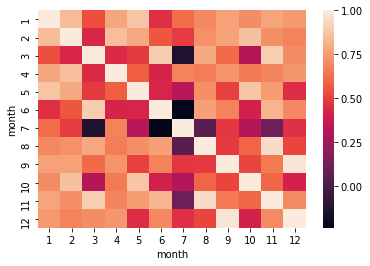

In [26]:
passengers_corr_month = df.groupby([
    df['datetime'].dt.month.rename('month'),
    df['datetime'].dt.weekday.rename('weekday')])['passengers_in'].sum()

passengers_corr_month = passengers_corr_month.unstack(0)

display(passengers_corr_month)

corr = passengers_corr_month.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Correlation heatmap shows that 9 and 12, 8 and 11, 3 and 11, 2 and 10 months passengers flow was very similar. On the other hand 3 and 7, 6 and 7, 8 and 7, 11 and 7 months passengers flow was different. 6, 7, 8 months are very different, because passengers traffic flow on those moths was lowest.

## Passengers flow trend

I guess no trend occurs in the data. Passengers flow rise and fall with no particular pattern, but lets test that.

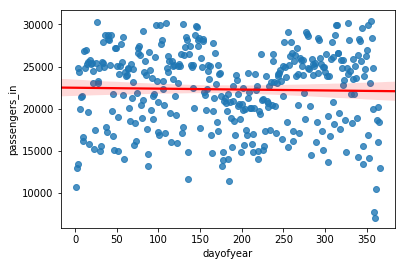

In [27]:
passengers_by_date = df.groupby([
    df['datetime'].dt.dayofyear.rename('dayofyear')])['passengers_in'].sum().reset_index()

sns.regplot(x='dayofyear', 
            y='passengers_in', 
            data=passengers_by_date,
            line_kws={'color': 'red'})

After performing linear regression analysis I can see that no linear trend exists. 